In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [28]:
import uproot

N = 1e6
list_of_features = "v0_ks_mass v0_rxy v0_chi2 cosTheta".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(list_of_features,entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(list_of_features+['trueKs'],entrystop = N)

In [29]:
xlim = np.percentile(data.v0_ks_mass,[0.01,99.99])
vals, bins = np.histogram(data.v0_ks_mass,bins=1000,range=xlim)
binc = 0.5*(bins[1:] + bins[:-1])

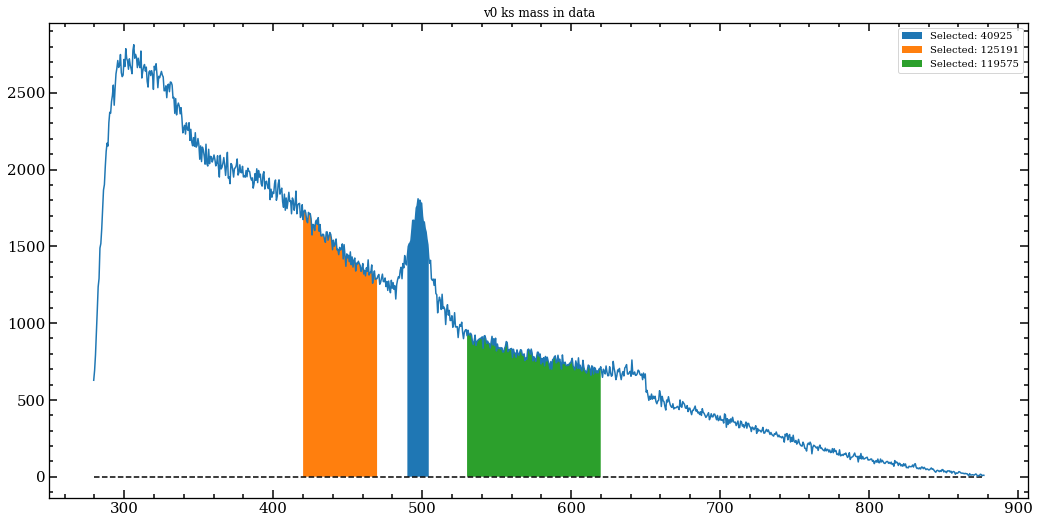

In [30]:
signal_cuts = [490,505]
background_cuts = [420,470,530,620]

signal_mask = (binc>signal_cuts[0])*(binc<signal_cuts[1])
background_mask1 = (binc>background_cuts[0])*(binc<background_cuts[1])
background_mask2 = (binc>background_cuts[2])*(binc<background_cuts[3])


fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('v0 ks mass in data')

ax.plot(binc,vals)
ax.hlines(0,min(binc),max(binc),color='k',linestyle='--')
ax.fill_between(binc[signal_mask],vals[signal_mask],label=f'Selected: {vals[signal_mask].sum()}')
ax.fill_between(binc[background_mask1],vals[background_mask1],label=f'Selected: {vals[background_mask1].sum()}')
ax.fill_between(binc[background_mask2],vals[background_mask2],label=f'Selected: {vals[background_mask2].sum()}')

ax.legend()

In [67]:
data_signal = data.loc[(data.v0_ks_mass>signal_cuts[0])&(data.v0_ks_mass<signal_cuts[1])]
data_background = data.loc[(data.v0_ks_mass>background_cuts[0])&(data.v0_ks_mass<background_cuts[1])|(data.v0_ks_mass>background_cuts[2])&(data.v0_ks_mass<background_cuts[3])]

print(f"ratio of signal: {data_signal.__len__()/(data_signal.__len__() + data_background.__len__())}")

ratio of signal: 0.1441649606174786


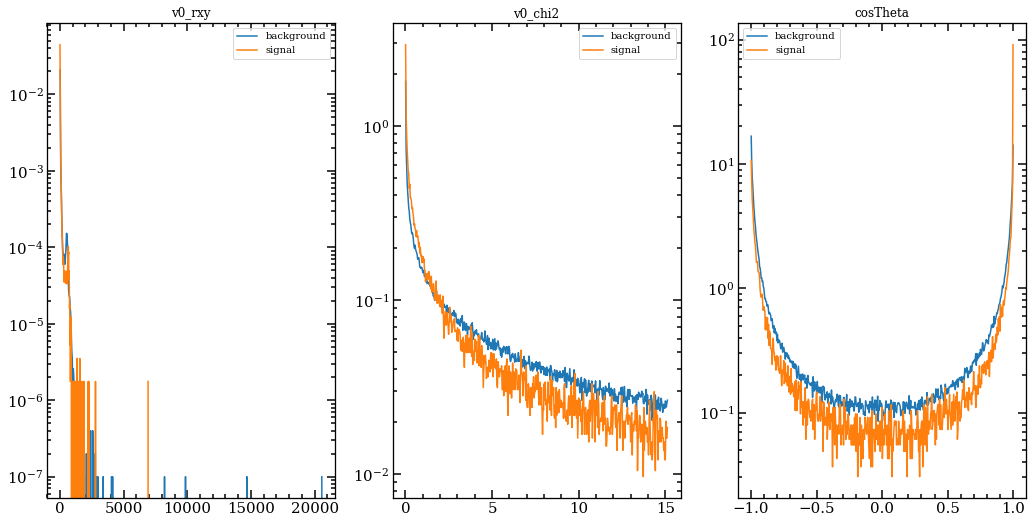

In [34]:
fig, ax = plt.subplots(figsize=(16,8),ncols=3)
for i, feat in enumerate(['v0_rxy','v0_chi2','cosTheta']):
    vals, bins = np.histogram(data_background[feat],bins=500,density=True)
    binc = 0.5*(bins[1:] + bins[:-1])
    ax[i].plot(binc,vals,label='background')

    vals,bins = np.histogram(data_signal[feat],bins=500,density=True)
    binc = 0.5*(bins[1:] + bins[:-1])
    ax[i].plot(binc,vals,label='signal')

    ax[i].set_title(f'{feat}')
    ax[i].set_yscale('log')
    ax[i].legend()

In [35]:
signal_slice = int(data_signal.__len__()*0.7)
background_slice = int(data_background.__len__()*0.7)

train_data = pd.concat([data_signal[:signal_slice],data_background[:background_slice]],axis=0)

test_data = pd.concat([data_signal[signal_slice:],data_background[background_slice:]],axis=0)

In [36]:
# train_weight = compute_sample_weight('balanced',
#                                      y=np.append(np.ones(signal_slice),np.zeros(background_slice)))

In [81]:
clf = AdaBoostClassifier(n_estimators=100,random_state=42)

clf.fit(X=train_data[['v0_rxy','v0_chi2','cosTheta']],
        y=np.append(np.ones(signal_slice),np.zeros(background_slice)))

# clf.fit(X=train_data[['v0_rxy','v0_chi2','cosTheta']],
#         y=np.append(np.ones(signal_slice),np.zeros(background_slice)),
#        sample_weight=train_weight)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [82]:
score = clf.score(X=test_data[['v0_rxy','v0_chi2','cosTheta']],
            y=np.append(np.ones(data_signal.__len__() - signal_slice),np.zeros(data_background.__len__() - background_slice)))
score

0.8818840494890733

In [83]:
pred = clf.predict_proba(X=test_data[['v0_rxy','v0_chi2','cosTheta']])

See how it holds up on MC data. (perhaps better proxy for accuracy since there are no false positives)

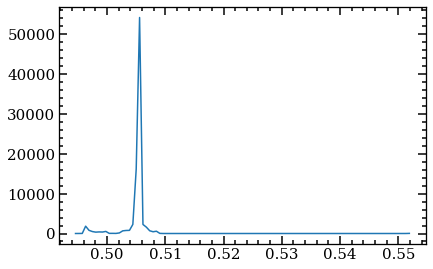

In [91]:
from HomeMade import hist
from sklearn.metrics import roc_auc_score, roc_curve

vals, binc, binwidth = hist(pred[:,0],bins=100,range=list(np.percentile(pred[:,0],[0,100])))

fig, ax = plt.subplots()
ax.plot(binc,vals)

In [93]:
score_mc = clf.score(X=mc[['v0_rxy','v0_chi2','cosTheta']],
                     y=mc.trueKs)
pred_mc = clf.predict_proba(X=mc[['v0_rxy','v0_chi2','cosTheta']])
score_mc, roc_auc_score(mc.trueKs,pred_mc[:,1])

(0.919976, 0.9485301437719831)

In [86]:
1-(mc.trueKs).sum()/mc.__len__()

0.907363

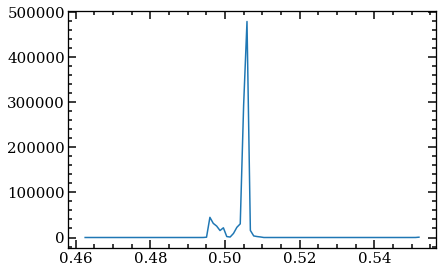

In [88]:
vals, binc, binwidth = hist(pred_mc[:,0],bins=100,range=list(np.percentile(pred_mc[:,0],[0,100])))

fig, ax = plt.subplots()
ax.plot(binc,vals)

NameError: name 'roc_auc_score' is not defined